<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%206%20-%20Aprendizaje%20por%20Transferencia%20y%20puesta%20a%20punto%20de%20parámetros%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)

## Paso 1: Instalación de dependencias y configuración del entorno en GPU

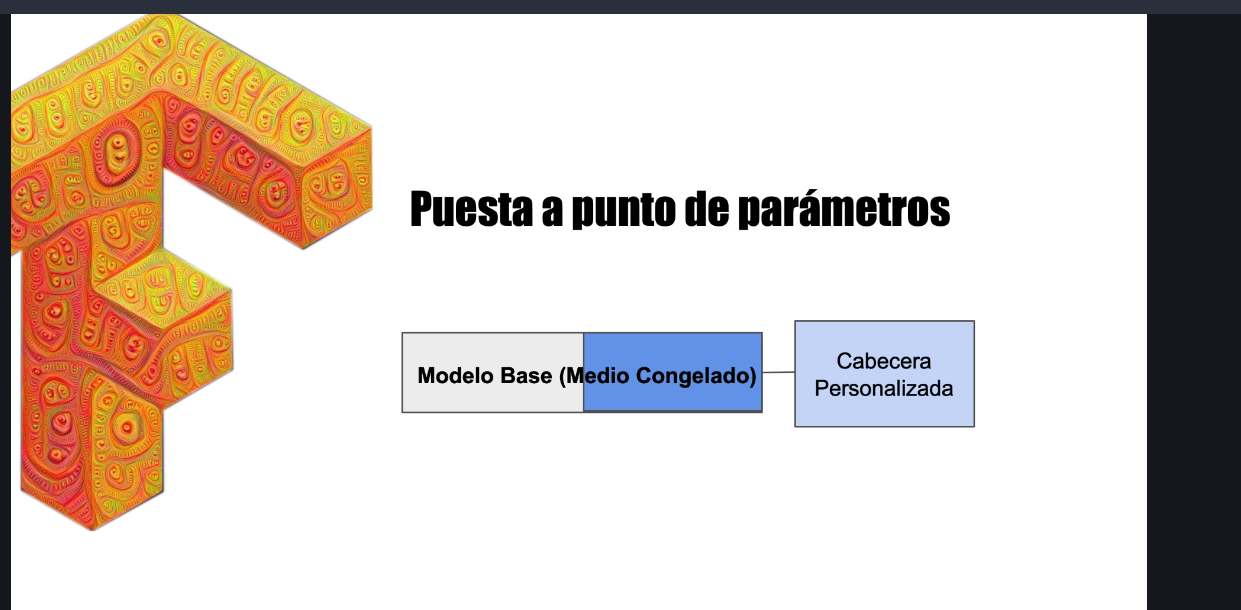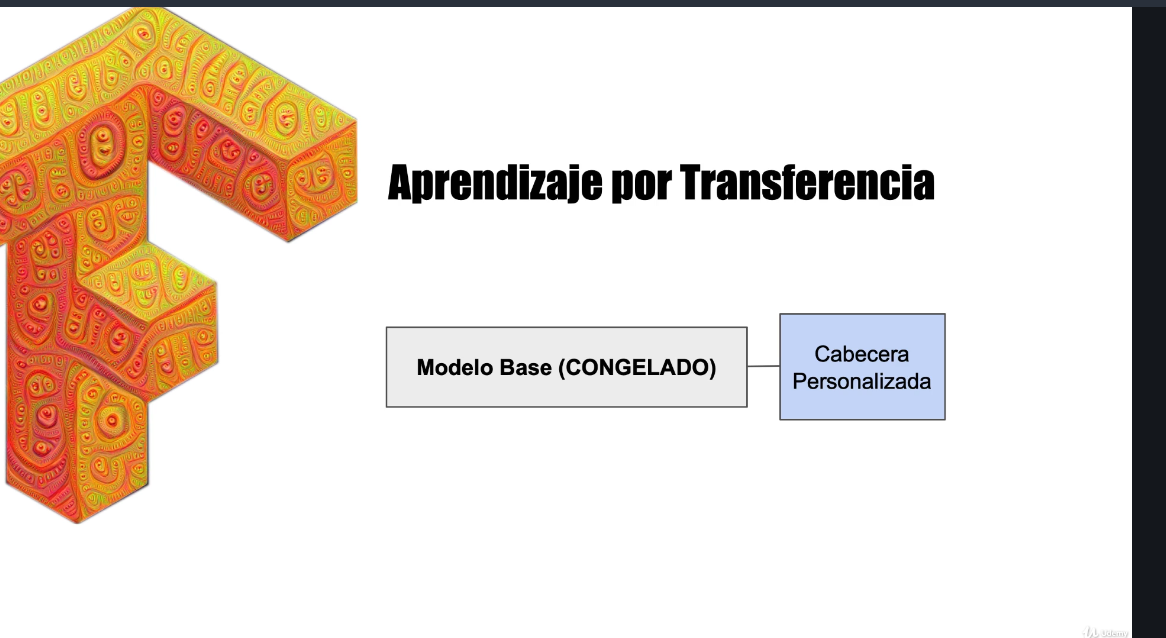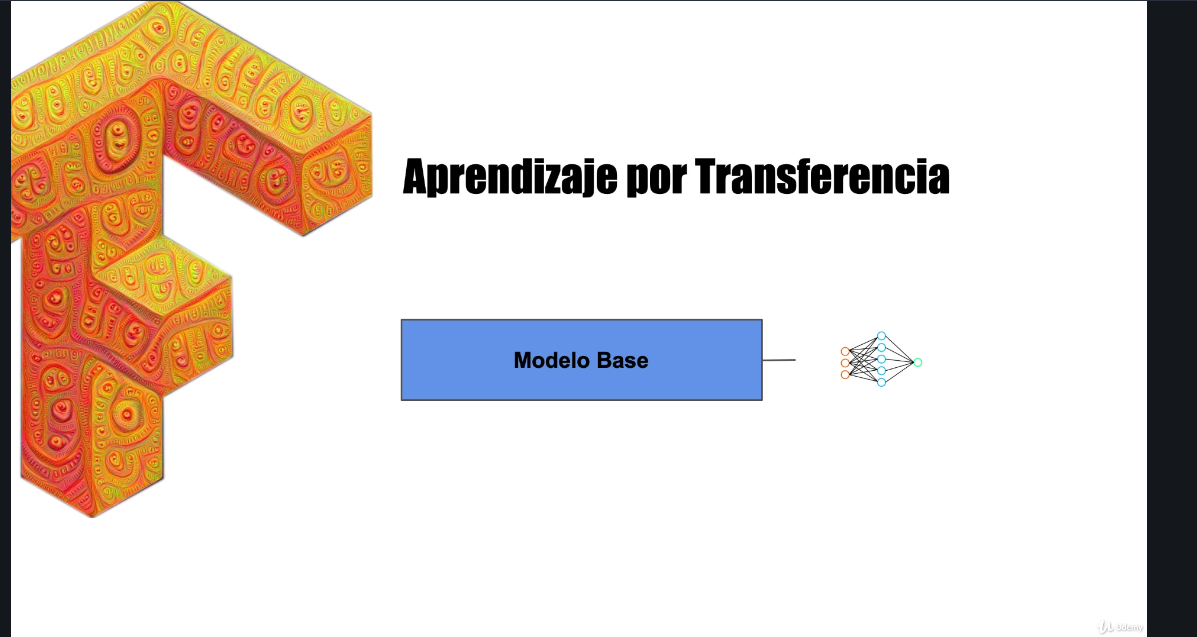

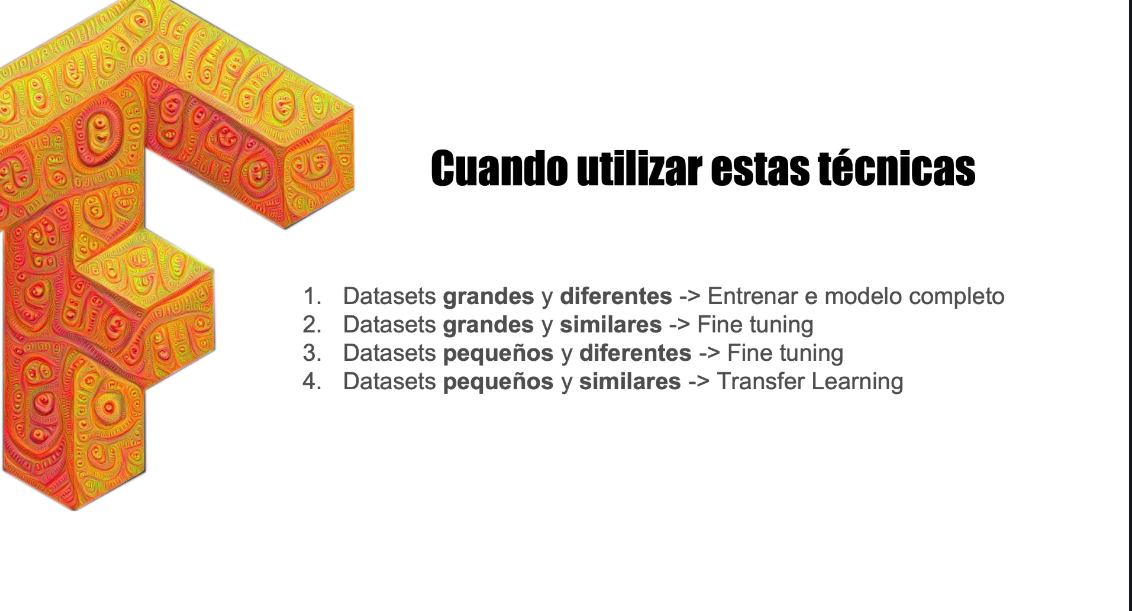

In [1]:
#!pip install tensorflow-gpu==2.0.0.alpha0
%tensorflow_version 2.x

In [2]:
!pip install tqdm

### Descargar el dataset de Perros vs Gatos

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2021-04-02 03:34:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  41.8MB/s    in 1.6s    

2021-04-02 03:34:08 (41.8 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Paso 2: Pre procesado del data set

### Importar las dependencias del proyecto

In [4]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.4.1'

### Descomprimir el dataset de Perros vs Gatos

In [5]:
dataset_path = "./cats_and_dogs_filtered.zip"

In [6]:
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")

In [7]:
zip_object.extractall("./")

In [8]:
zip_object.close()

### Configurar las rutas al dataset

In [9]:
dataset_path_new = "./cats_and_dogs_filtered/"

In [10]:
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

## Construir el Modelo

### Cargar un modelo pre entrenado (MobileNetV2)

In [11]:
IMG_SHAPE = (128, 128, 3)

en include top = false me indica que la cabecera final o capa final sera una que provea yo, una capa customizada según mis fines.

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

con esto evitamos que se cambien los pesos de la red neuronal que ocupamos de base cuando entrenamos, ya que si lo hace va a tratar de aprender estos parametros y no nos va a servir la red neuronal que ocupamos como base, asi solo nos enfocamos en entrenar las capas customizadas (en este caso al fina) que agregamos.

### Congelar el modelo base

In [14]:
base_model.trainable = False

### Definir la cabecera personalizada para nuestra red neuronal

podriamos aplanar la tupla de vectores , pero en este caso vamos a resumir esta informacion en una sola capa , es una tecnica de pulling con una capa de la red, en este caso promediamos los 4x4 valores, en vez de un max polling hacemos un prom polling

In [15]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [17]:
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [18]:
prediction_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_average_layer)

### Definir el modelo

In [19]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________



### Compilar el modelo

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

### Crear generadores de datos

Redimensionar imágenes

    Las grandes arquitecturas pre-entrenadas solamente soportan cierto tipo de tamaños de imágenes.
    
Por ejemplo: MobileNet (la arquitectura que nosotros usamos) soporta: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224).

In [29]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

ahora creo las imagenes en segundo plano, escalo las imagenes en 128x128


In [30]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.


In [31]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode="binary")

Found 1000 images belonging to 2 classes.


### Entrenar el modelo 

el fit_generator puede entrenar y validar a la vez, el primer epoch tarda mas 

In [32]:
model.fit_generator(train_generator, epochs=8, validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
16/16 [==============================] - 40s 517ms/step - loss: 0.7741 - accuracy: 0.6115 - val_loss: 0.6478 - val_accuracy: 0.6750
Epoch 2/8
16/16 [==============================] - 7s 462ms/step - loss: 0.5923 - accuracy: 0.7147 - val_loss: 0.5535 - val_accuracy: 0.7460
Epoch 3/8
16/16 [==============================] - 7s 450ms/step - loss: 0.5238 - accuracy: 0.7586 - val_loss: 0.4858 - val_accuracy: 0.7890
Epoch 4/8
16/16 [==============================] - 7s 449ms/step - loss: 0.4568 - accuracy: 0.8175 - val_loss: 0.4311 - val_accuracy: 0.8280
Epoch 5/8
16/16 [==============================] - 7s 451ms/step - loss: 0.4168 - accuracy: 0.8409 - val_loss: 0.3851 - val_accuracy: 0.8650
Epoch 6/8
16/16 [==============================] - 7s 449ms/step - loss: 0.3652 - accuracy: 0.8634 - val_loss: 0.3462 - val_accuracy: 0.8840
Epoch 7/8
16/16 [==============================] - 7s 449ms/step - loss: 0.3235 - accuracy: 0.8909 - val_loss: 0.3127 - val_accuracy: 0.8980
Epoch 8/8
16

### Evaluar el modelo de aprendizaje por transferencia

In [37]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 [==============================] - 2s 298ms/step - loss: 0.2847 - accuracy: 0.9090


In [38]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.9089999794960022


## Puesta a punto de parámetros


Un par de cosas:

- NUNCA HAY QUE USAR la puesta a punto (fine tuning) de parámetros en toda la red neuronal: con algunas de las capas superiores (las finales) es más que suficiente suficiente. En la mayoría de casos, son las más especializadas. El objetivo del fine tuning es adaptar esa parte específica de la red neuronal para nuestro nuevo dataset específico.
- Empezar con la puesta a punto DESPUÉS de haber finalizado la fase de aprendizaje por transferencia. Si intentamos hacer el Fine tuning inmediatamente, los gradientes serán muy diferentes entre nuestra cabecera personalizada de la red neuronal y las nuevas capas no congeladas del modelo base.

### Descongelar unas cuantas capas superiores del modelo

In [39]:
base_model.trainable = True

In [40]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 154


In [41]:
fine_tune_at = 100

In [42]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compilar el modelo para la puesta a punto

In [43]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Puesta a punto

In [44]:
model.fit_generator(train_generator,  
                    epochs=5, 
                    validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
16/16 [==============================] - 12s 506ms/step - loss: 0.2690 - accuracy: 0.8886 - val_loss: 0.0973 - val_accuracy: 0.9650
Epoch 2/5
16/16 [==============================] - 7s 449ms/step - loss: 0.0305 - accuracy: 0.9979 - val_loss: 0.1041 - val_accuracy: 0.9620
Epoch 3/5
16/16 [==============================] - 7s 458ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9580
Epoch 4/5
16/16 [==============================] - 7s 452ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9550
Epoch 5/5
16/16 [==============================] - 7s 451ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1782 - val_accuracy: 0.9540


### Evaluar el modelo re calibrado

In [47]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 [==============================] - 2s 293ms/step - loss: 0.1782 - accuracy: 0.9540


In [48]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.9539999961853027
